# Two Moons

<div class="btn btn-notebook" role="button">
    <img src="../_static/images/colab_logo_32px.png"> [Run in Google Colab](https://colab.research.google.com/drive/1Tz-TIkHI8ashHP90Im6D3tMjZ3lkR7s6?usp=sharing)
</div>
<div class="btn btn-notebook" role="button">
    <img src="../_static/images/github_logo_32px.png"> [View on GitHub](https://github.com/adapt-python/notebooks/blob/d0364973c642ea4880756cef4e9f2ee8bb5e8495/Two_moons.ipynb)
</div>

The following example is a binary classification domain adaptation issue. The goal is to learn the classification task on the target data (black points) knowing only the labels on the source data (red and blue points).

The following methods are being tested:

- [Source Only](#Source-Only)
- [DANN](#DANN)
- [ADDA](#ADDA)
- [Deep CORAL](#DeepCORAL)
- [mSDA](#mSDA)

In [1]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2

from adapt.feature_based import DANN, ADDA, mSDA, DeepCORAL

## Setup

In [2]:
def make_moons_da(n_samples=100, rotation=30, noise=0.05, random_state=0):
    Xs, ys = make_moons(n_samples=n_samples,
                        noise=noise,
                        random_state=random_state)
    Xs[:, 0] -= 0.5
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rot_matrix = np.array(
        ((cos_theta, -sin_theta),
         (sin_theta, cos_theta))
    )
    Xt = Xs.dot(rot_matrix)
    yt = ys
    return Xs, ys, Xt, yt

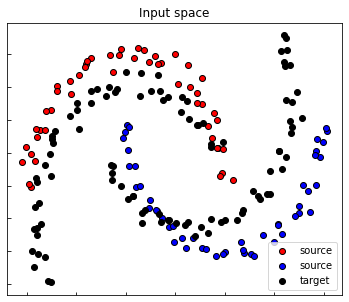

In [3]:
Xs, ys, Xt, yt = make_moons_da()

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

## Network

In [4]:
def get_task():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

<a name="Source-Only"></a>
## Source Only

For source only, we use a DANN instance with lambda set to zero. Thus, the gradient of the discriminator is not back-propagated through the encoder.

In [5]:
src_only = DANN(task=get_task(), loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=0., metrics=["acc"], gamma=10., random_state=0)

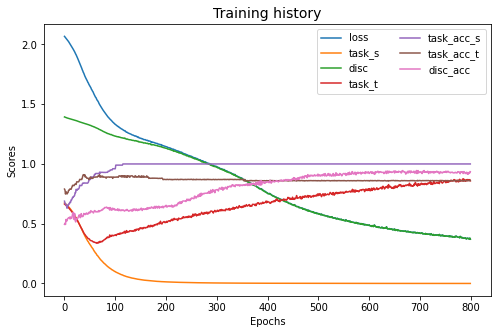

In [6]:
src_only.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(src_only.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [7]:
yt_pred = src_only.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = src_only.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((src_only.predict_features(Xs),
                        src_only.predict_features(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

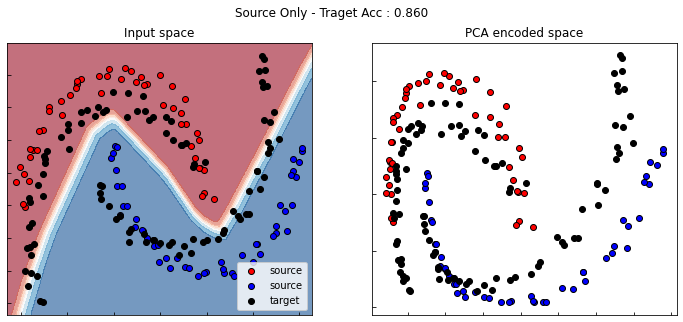

In [8]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="DANN"></a>
## [DANN](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DANN.html)

In [9]:
dann = DANN(task=get_task(), loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=1., metrics=["acc"], gamma=10., random_state=0)

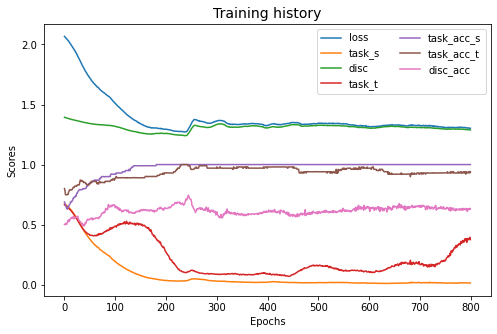

In [10]:
dann.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [11]:
yt_pred = dann.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = dann.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((dann.encoder_.predict(Xs),
                        dann.encoder_.predict(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

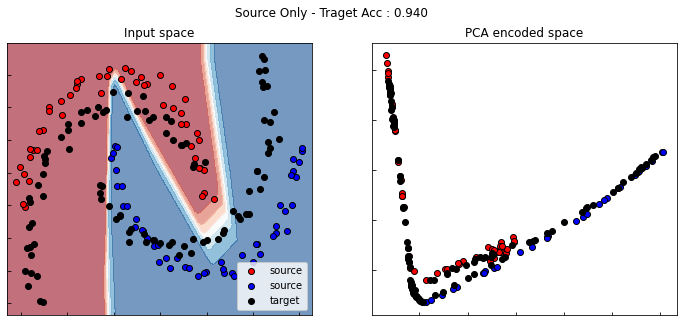

In [12]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="ADDA"></a>
## [ADDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.ADDA.html)

In [13]:
adda = ADDA(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

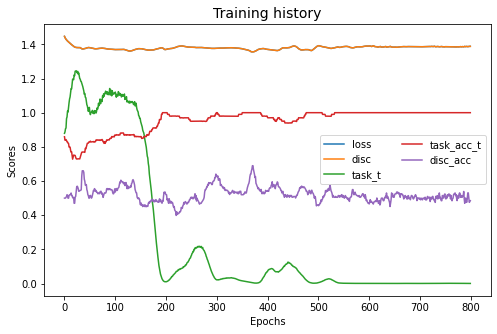

In [14]:
adda.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(adda.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [15]:
yt_pred = adda.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = adda.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((adda.encoder_.predict(Xs),
                        adda.encoder_.predict(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

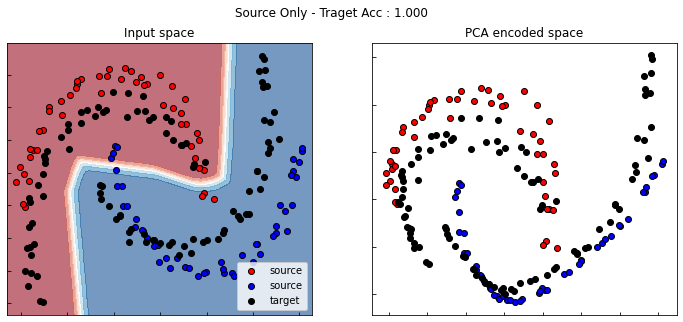

In [16]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="DeepCORAL"></a>
## [DeepCORAL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DeepCORAL.html)

In [17]:
dcoral = DeepCORAL(encoder=src_only.encoder_, 
                   task=src_only.task_, lambda_=1000.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

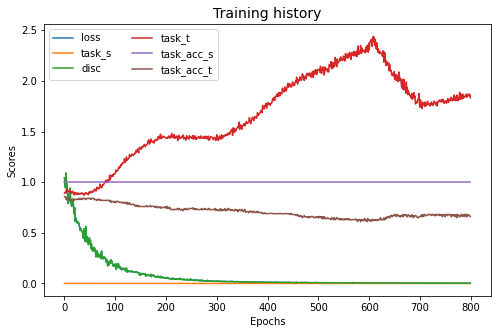

In [18]:
dcoral.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(dcoral.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [19]:
yt_pred = dcoral.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = dcoral.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((dcoral.encoder_.predict(Xs),
                        dcoral.encoder_.predict(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

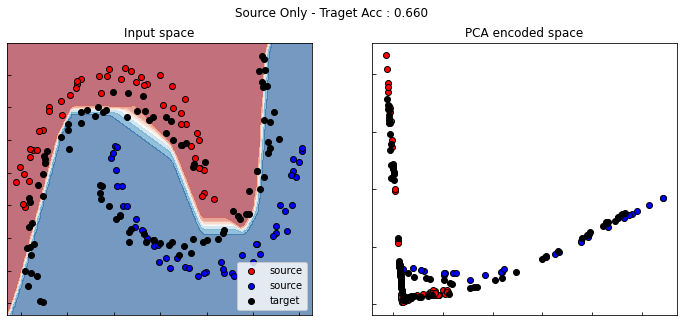

In [20]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="mSDA"></a>
## [mSDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.mSDA.html)

In [21]:
estimator = get_task()
estimator.compile(loss="bce", optimizer=Adam(0.001, beta_1=0.5))
msda = mSDA(estimator=estimator, noise_lvl=0.2,
            loss="mse", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, random_state=0)

In [22]:
msda.fit_embeddings(Xs, Xt, epochs=100, batch_size=34, verbose=0);

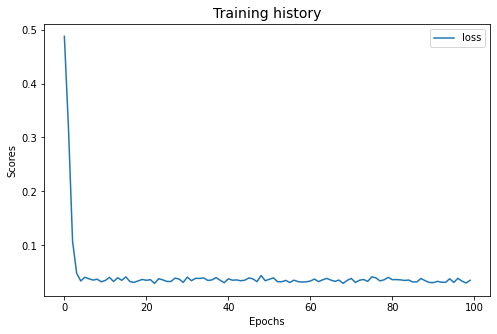

In [23]:
msda.fit_estimator(msda.encoder_.predict(Xs), ys, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(msda.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [24]:
yt_pred = msda.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = msda.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((msda.encoder_.predict(Xs),
                        msda.encoder_.predict(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

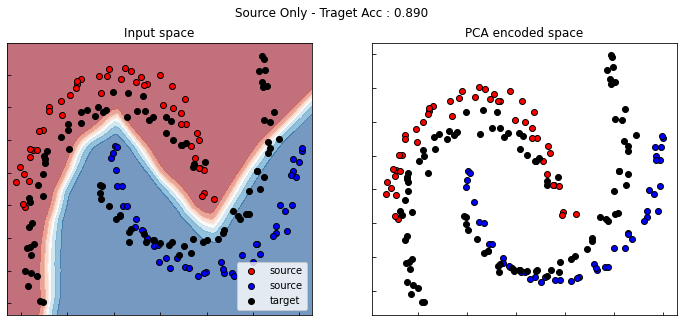

In [25]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()